# 1. 环境初始化

In [1]:
import sys
import os
from pathlib import Path

# 将当前目录添加到 sys.path
current_dir = Path(os.getcwd())
sys.path.append(str(current_dir))

# 导入 Core 基建
from core import check_api_keys, print_html, ensure_execute_python_tags, extract_code_from_tags

# 导入业务逻辑
from agent_logic import (
    load_and_prepare_data, 
    make_schema_text, 
    generate_chart_code, 
    reflect_on_image_and_regenerate,
    execute_chart_code
)

print("✅ 环境初始化完成")
check_api_keys()

✅ 环境初始化完成
🔑 API Keys Configuration Status:
  ❌ OpenAI
  ❌ Anthropic
  ✅ Qwen
  ✅ Zhipu
  ✅ DeepSeek
  ✅ Moonshot



## 2. 定义工作流 (Workflow)

我们将 `run_workflow` 函数直接写在 Notebook 中，作为流程编排层。这样可以清晰地看到 Agent 是如何思考和迭代的。

In [2]:
from pathlib import Path
import base64
from IPython.display import HTML, display

def run_chart_gen_workflow(
    dataset_path: str,
    user_instruction: str,
    generation_model: str = "qwen-plus",
    reflection_model: str = "glm-4v",
    image_basename: str = "chart"
):
    """
    执行图表生成工作流：Generate -> Execute -> Reflect -> Regenerate
    """
    print_html(f"🚀 开始任务: {user_instruction}", title="System Start")
    
    # 1. 加载数据
    try:
        df = load_and_prepare_data(dataset_path)
        schema = make_schema_text(df)
        print_html(df.head(), title="📊 数据预览")
    except Exception as e:
        print_html(f"数据加载失败: {e}", title="❌ Error")
        return

    # 2. 生成初始代码 (V1)
    out_path_v1 = f"{image_basename}_v1.png"
    try:
        print_html(f"正在使用 {generation_model} 生成代码...", title="Step 1: Generate")
        response_v1 = generate_chart_code(user_instruction, schema, generation_model, out_path_v1)
        
        # 清洗代码
        response_v1 = ensure_execute_python_tags(response_v1)
        code_v1 = extract_code_from_tags(response_v1)
        print_html(code_v1, title="📝 Generated Code (V1)")
        
        # 执行代码
        execute_chart_code(code_v1, df)
        if Path(out_path_v1).exists():
            print_html(out_path_v1, title="📊 Chart V1", is_image=True)
        else:
            print_html("图表文件未生成", title="⚠️ Warning")
            
    except Exception as e:
        print_html(f"生成阶段失败: {e}", title="❌ Error")
        return

    # 3. 反思与改进 (Reflect)
    out_path_v2 = f"{image_basename}_v2.png"
    try:
        print_html(f"正在使用 {reflection_model} 进行视觉反思...", title="Step 2: Reflect")
        
        feedback, code_v2 = reflect_on_image_and_regenerate(
            out_path_v1, user_instruction, schema, reflection_model, out_path_v2, code_v1
        )
        
        print_html(feedback, title="🤔 Reflection Feedback")
        print_html(code_v2, title="📝 Refined Code (V2)")
        
        # 执行改进后的代码
        execute_chart_code(code_v2, df)
        if Path(out_path_v2).exists():
            print_html(out_path_v2, title="📊 Chart V2 (Improved)", is_image=True)
            
    except Exception as e:
        print_html(f"反思阶段失败: {e}", title="❌ Error")
        return

    print_html("✅ 工作流完成", title="System End")

## 3. 运行演示

请确保 `coffee_sales.csv` 文件在当前目录下（或提供绝对路径）。

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-03-01,06:14,card,ANON-0000-0000-0001,3.87,Latte,1,3,2024
2024-03-01,11:10,card,ANON-0000-0000-0002,3.87,Hot Chocolate,1,3,2024
2024-03-01,11:19,card,ANON-0000-0000-0002,3.87,Hot Chocolate,1,3,2024
2024-03-01,11:37,card,ANON-0000-0000-0003,2.89,Americano,1,3,2024
2024-03-01,12:56,card,ANON-0000-0000-0004,3.87,Latte,1,3,2024



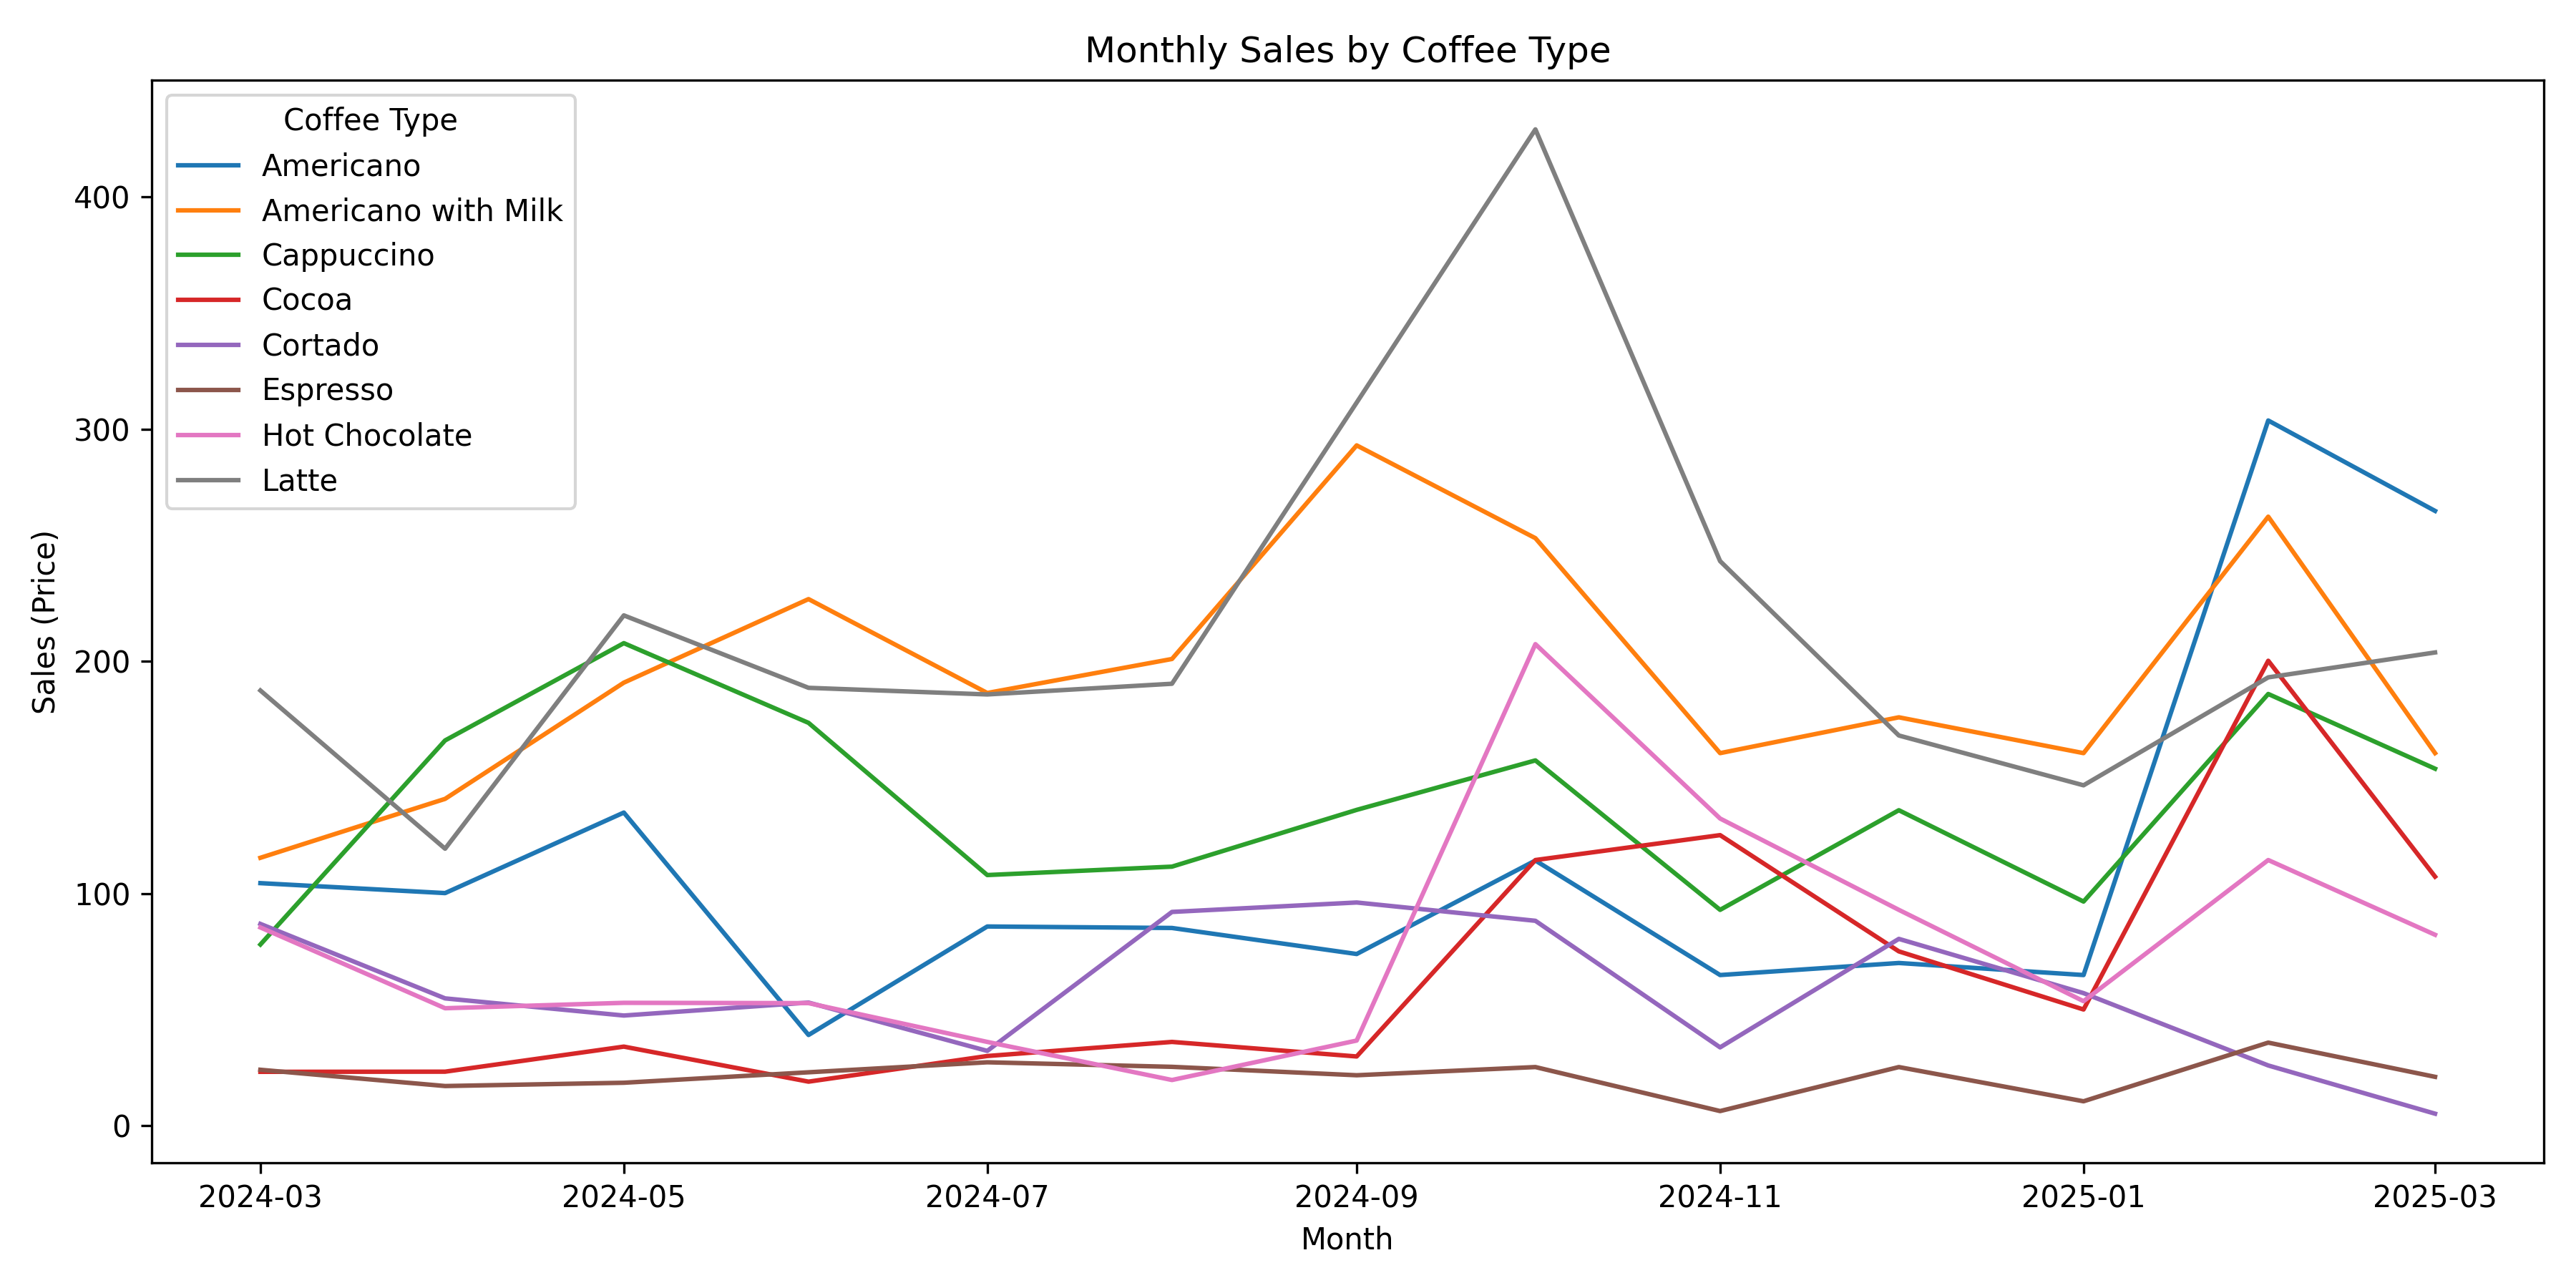


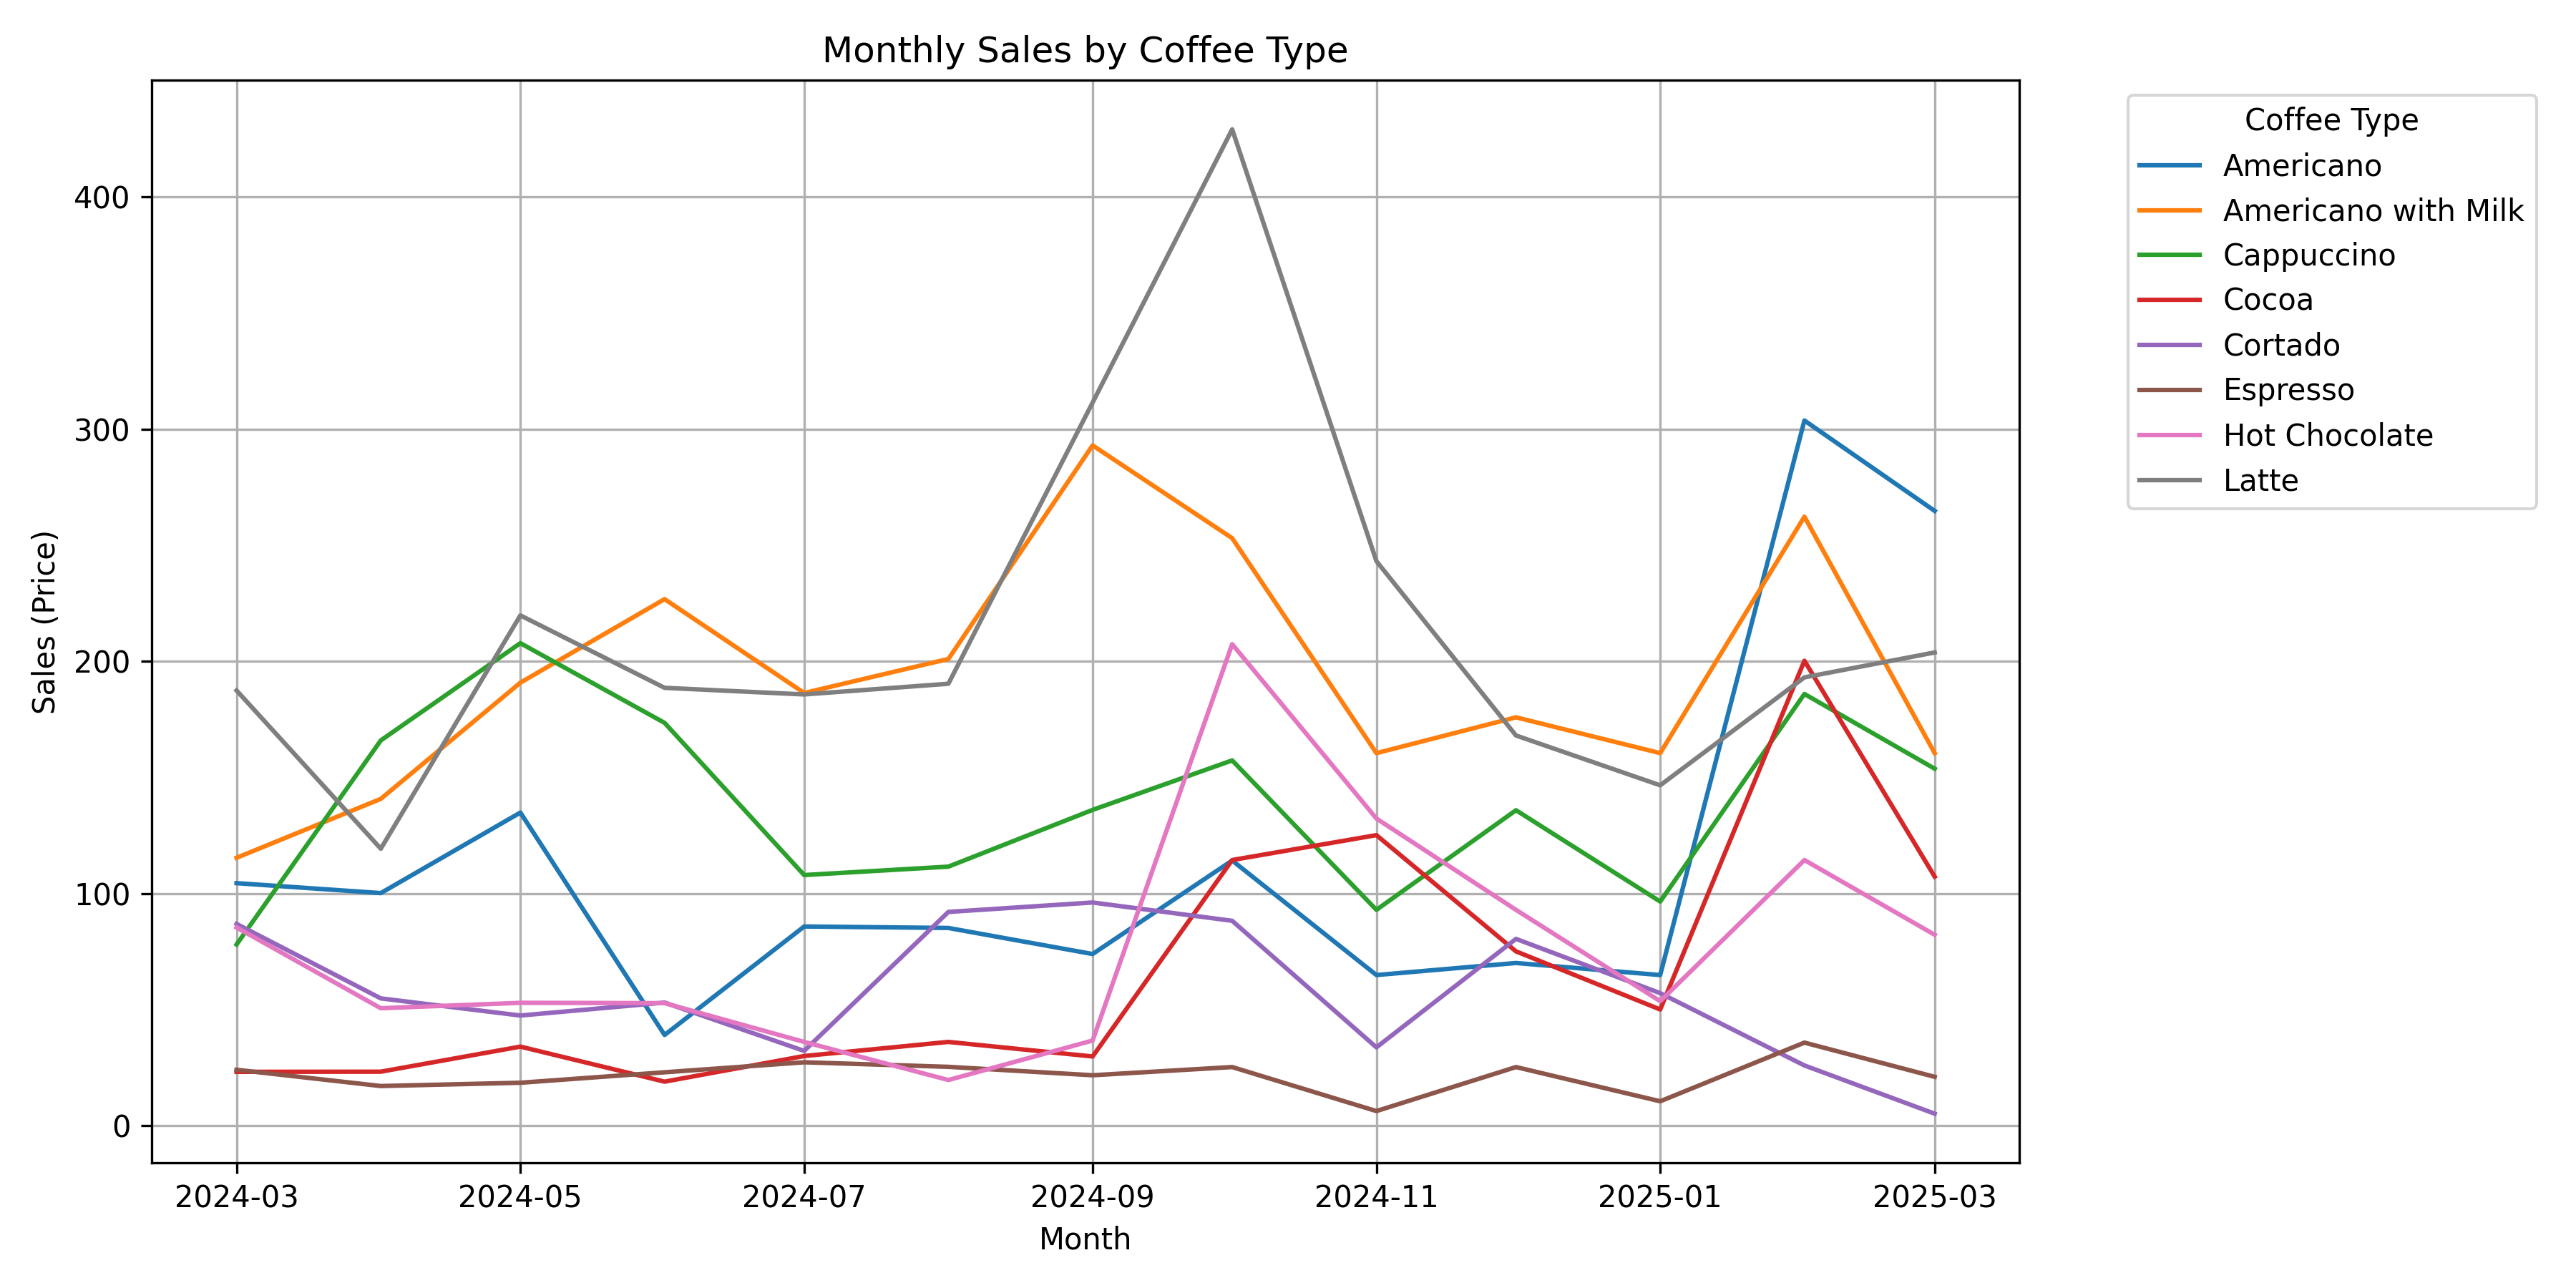

In [3]:
# 配置参数
DATASET_PATH = "coffee_sales.csv" # 假设数据在上一级目录的 agent 文件夹中
INSTRUCTION = "画一个展示不同产品类型销售额随时间变化的折线图，按月汇总。"

# 运行
run_chart_gen_workflow(
    dataset_path=DATASET_PATH,
    user_instruction=INSTRUCTION,
    generation_model="qwen3-max", # 或 gpt-4o
    reflection_model="qwen-vl-plus"     # 或 qwen-vl-plus
)